<H1>Large Scale Distributed Data Science using Apache Spark </H!>

By James G. Shanahan1, 2 and Liang Dai1, 3 <P>
1 NativeX and iSchool, 2 UC Berkeley, CA, 3  UC Santa Cruz <P>

EMAIL: James_DOT_Shanahan_AT_gmail_DOT_com

#  KMeans<P>
Data Generation

In [2]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data/KMdata.csv',data,delimiter = ',')

# Data Visualiazation

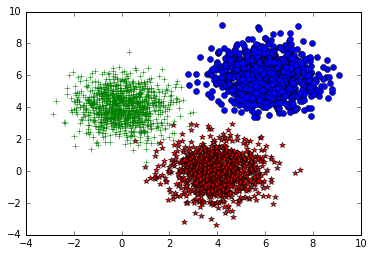

In [3]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

# Set enviroment variable for PySpark

In [4]:
import os
import sys #current as of 9/26/2015
import pyspark
from pyspark.sql import SQLContext
# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)
print(sc)
print(sqlContext)
# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

In [5]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

In [31]:
import numpy as np

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data/KMdata.csv").cache()
iter_num = 0

#assign to a centroid
res = D.map(lambda point: nearest_centroid(point)) \
    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
    .sortByKey()

for x in res.collect():
    print (x)
#np.array([x[1][0]/x[1][1] for x in res])
    

        

(0, (array([ 173.66559812,    2.35673537]), 131))
(1, (array([ 8284.8972113 ,  5551.22189654]), 2091))
(2, (array([ 1603.0041115 ,  4437.50799001]), 778))


## Distributed KMeans in Spark

# Quiz : fill in the missing line of code below

I.e., res = D.map() # fill in the missing code

Iteration0
[[ 1.32569159  0.01799035]
 [ 3.96216988  2.65481678]
 [ 2.0604166   5.70373778]]


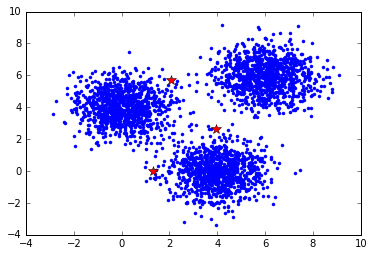

Iteration1
[[ 2.56260231  0.1887731 ]
 [ 5.46599439  3.00256811]
 [ 2.05418674  5.20591566]]


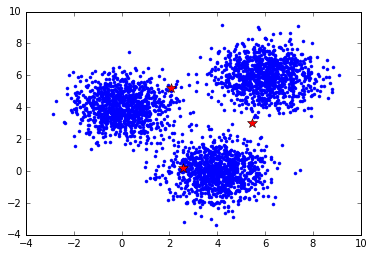

Iteration2
[[ 3.58057123 -0.04092245]
 [ 6.16606831  5.09421469]
 [ 0.84725486  4.60479377]]


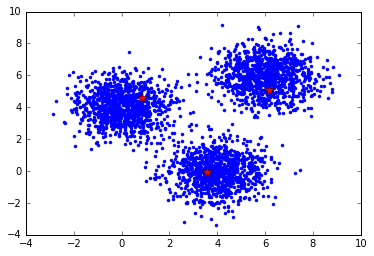

Iteration3
[[ 3.96722915 -0.02593485]
 [ 6.0558526   5.95680156]
 [ 0.06606938  4.04774332]]


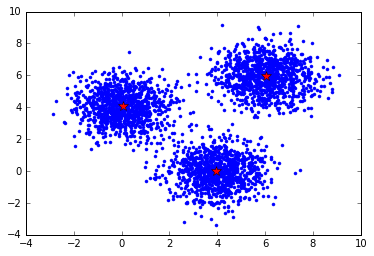

Iteration4
[[ 3.98131615 -0.01912028]
 [ 6.04226687  5.9720779 ]
 [ 0.05183329  4.03196693]]


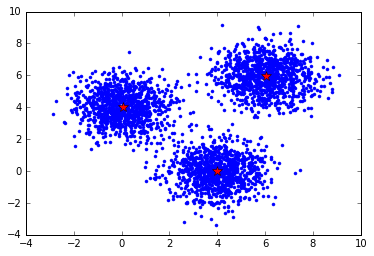

Final Results:
[[ 3.98131615 -0.01912028]
 [ 6.04226687  5.9720779 ]
 [ 0.05183329  4.03196693]]


In [33]:
import numpy as np

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data/KMdata.csv").cache()
iter_num = 0
for i in range(10):  
    #assign to a centroid
    res = D.map(lambda point: nearest_centroid(point)) \
        .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
        .sortByKey()
    res = res.collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print ("Iteration" + str(iter_num))
    iter_num = iter_num + 1 
    centroids = centroids_new
    print (centroids)
    plot_iteration(centroids)
print ("Final Results:")
print (centroids)

#MLlib Kmeans

http://spark.apache.org/docs/latest/mllib-clustering.html

In [8]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = sc.textFile("data/KMdata.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=20,
        runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid

[-0.02990683  3.97135809]
[ 5.96404527  6.00357836]
[ 4.02528864 -0.03400055]
